**Outline**

The purpose of this scripts is to make a figure (Figure 1 in the long PMBR MS) showing:
1. Reported ISIs in a selection of publications
2. The distribution of ISI's in the Cam-CAN button-press dataset

**Import packages**

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import itertools

from tqdm import tqdm

**Define data directories and file names, load data**

In [3]:
# Define input path
data_path = os.path.join("/media/NAS/lbailey/PMBR_timecourse/output")

# Define path to numpy events arrays
event_numpy_path = os.path.join(data_path, 'event_numpys')

# Define path to demographics csv
demographics_fname = "/home/timb/camcan/proc_data/demographics_allSubjects.csv"

# Define path to the xlsx file containing ISI ranges for each study
study_isis_fname = os.path.join(data_path, "Table_of_ISIs.xlsx")

# Load the demographics file and extract the subject list
df_demo = pd.read_csv(demographics_fname)
subject_list = list(df_demo.loc[(df_demo['RawExists'] == 1)]['SubjectID'])

# Study ISIs file
df_study_isis = pd.read_excel(study_isis_fname)

# Citation column was misspelled - correct this
df_study_isis.rename(columns={'Cittaion': 'Citation'}, inplace=True)

**Get cue ISIs from the CamCAN dataset**

Here we are extracting the time elapsed since the preceding button-press cue, for each trial

In [4]:
# Make an empty list to contain preceding ISI data for each subject_list
camcan_isis_orig = []
skipped_subjects = []


# Read each subject's event numpy and get preceding times for every cue
for subject in tqdm(subject_list):

    # First pull the rows from demo_df corresponding to this subject
    df_subject_demo = df_demo.copy().loc[(df_demo['SubjectID'] == subject)][['SubjectID', 'Age', 'Gender', 'Hand']]
    df_subject_demo.rename(columns={'SubjectID': 'subject', 'Age': 'age', 'Gender': 'gender', 'Hand': 'hand'}, inplace=True)

    # Read this subject's event numpy
    event_numpy_fname = os.path.join(event_numpy_path, subject + '-eve.txt')

    # Skip if no event numpy file exists for this subject
    if not os.path.exists(event_numpy_fname):
        skipped_subjects.append(subject)
        continue

    events = mne.read_events(os.path.join(event_numpy_path, subject + '-eve.txt'))

    # Subset cue events (codes 1-5) in the third column 
    cue_events = events[events[:,2] <= 5]

    # Convert to pandas and assign sensible names to columns. We can drop the middle column. 
    df = pd.DataFrame(cue_events[:,[0,2]], columns=['this_trial_t', 'event_code'])

    # Convert the first column to seconds
    df['this_trial_t'] = df['this_trial_t'] / 1000

    # Assign a new column with time of the PREVIOUS trial (first row in the new df will be null)
    df['prev_trial_t'] = df['this_trial_t'].shift(1)

    # Remove the first row
    df = df[1:].copy()

    # Create a new column representing time elapsed since the previous trial
    df['t_since_prev_trial'] = df['this_trial_t'] - df['prev_trial_t']

    # Convert df['t_since_prev_trial'] to a list and append to camcan_isis_orig
    camcan_isis_orig.append(df['t_since_prev_trial'].to_list())

# camcan_isis_orig is a list of lists, so concatenate it to make a single list
camcan_isis_concat = list(itertools.chain.from_iterable(camcan_isis_orig))


100%|██████████| 650/650 [00:01<00:00, 361.44it/s]


**Make Figure 1**

/tmp/ipykernel_49668/1184750464.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(['CamCAN dataset \n(2017)'], rotation=90, fontsize=10)


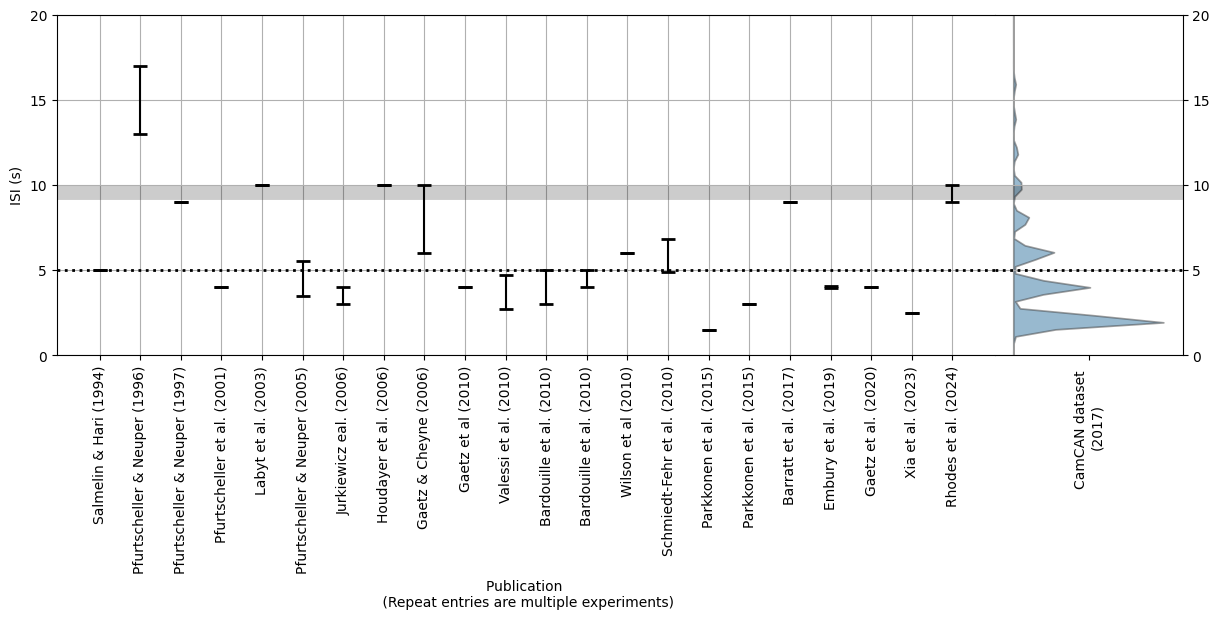

In [5]:
# Set up the figure. Axis 1 = study ISI data, Axis 2 = CamCAN ISI data
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey = False, gridspec_kw={'width_ratios': [5, 1]})

# Plot the Study ISI data as a series of points with error bars
ax[0].errorbar(df_study_isis.index, df_study_isis['Mean'], yerr=df_study_isis['upper-lower / 2'], 
             fmt='none', color='black', ecolor='black', capsize=5, capthick=2, marker = None)

# Set parameters for axis 1
ax[0].set_xticks(df_study_isis.index)
ax[0].set_xticklabels(df_study_isis['Citation'], rotation=90, fontsize=10)
ax[0].set_ylabel('ISI (s)')
ax[0].set_xlabel('Publication \n (Repeat entries are multiple experiments)')


# Plot the CamCAN ISI data as a violin plot
sns.violinplot(y = camcan_isis_concat, color='#1f77b4', split=True, inner=None, alpha=0.5, ax=ax[1])

# Set parameters for axis 2...

# Move the y ticks to the right of the violin plot
ax[1].yaxis.tick_right() 

# Add a tick label for the camcan data
ax[1].set_xticklabels(['CamCAN dataset \n(2017)'], rotation=90, fontsize=10) 
ax[1].invert_xaxis()

# Set shared parameters for both axes...

# There are very few events with preceding time > 20, so we will limit the y axis to <= 20
ax[0].set_ylim(0, 20)
ax[1].set_ylim(0, 20)

# Set the y ticks in increments of 5
ax[0].set_yticks(np.arange(0, 21, 5))
ax[1].set_yticks(np.arange(0, 21, 5))

# Remove edges of each subplot, so that they appear as one
ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)


# Add ISI benchmarks spanning both subplots
for a in ax:

    # Add a dotted line at 5s
    a.axhline(5, color='k', linestyle='dotted', linewidth=2)

    # Add a transparent bar at 9-10 seconds. The easiest way to do this is to put a very thick a horizontal line at 9.5
    a.axhline(9.5, color='k', linestyle='-', linewidth=10, alpha=0.2)

# # Add gridlines to both plots
ax[0].grid(True)
ax[1].grid(axis='y')

# Set tight layout
plt.tight_layout(pad=0)




**Print useful descriptive stats**

In [ ]:
# How many trials have preceding ISI < 3 s?
n_trials = sum(1 for i in camcan_isis_concat if i <= 5)

# What percentage of trials is this?
print(f"{n_trials} trials < 3 s ({n_trials / len(camcan_isis_concat) * 100:.2f}%)")


59646 trials < 3 s (74.52%)
3 trials > 20 s


In [7]:
# How many trials have preceding ISI > 20 s?
print(f"{sum(1 for i in camcan_isis_concat if i > 20)} trials > 20 s")

3 trials > 20 s
